# Look at isothermal displacements in the Gulf Stream area

This is a first exploration.
We focus on the global domain.


In [1]:
# import libraries

%matplotlib inline
from glob import glob
from netCDF4 import Dataset
#import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import gsw

from utils import *

# load grid info
grd = grid()

# define the zoom
di=200
zgrd = grd[900:900+di,800:800+di]

# output files
ofiles = sorted(glob(grd._datadir+'*avg*.nc'))
ofile = ofiles[0]

1 grid file found, uses: /home/datawork-lops-osi/jgula/NESED/nesea_grd.nc
vertical grid parameters found in /home/datawork-lops-osi/jgula/NESED/nesed_avg.00240.nc
-- Grid object
dim lon_rho: 1602  2002
lon_rho min= -7.212308e+01, max=-5.827296e+01
lat_rho min= 3.412333e+01, max=4.373431e+01
h min= 2.000000e+01, max=5.543070e+03
Lxi = 999.030393 km, Leta = 800.473014 km
 Generate a subset of the original grid
-- Grid object
dim lon_rho: 200  200
lon_rho min= -6.666013e+01, max=-6.518727e+01
lat_rho min= 3.913990e+01, max=4.027299e+01
h min= 1.862888e+03, max=4.697104e+03
Lxi = 99.996948 km, Leta = 99.986781 km


---

## Show zoom area



<type 'netCDF4._netCDF4.Variable'>
float32 temp(time, s_rho, eta_rho, xi_rho)
    long_name: averaged potential temperature
    units: Celsius
    field: temperature, scalar, series
    standard_name: sea_water_potential_temperature
    coordinates: lat_rho lon_rho
unlimited dimensions: time
current shape = (20, 50, 1602, 2002)
filling off



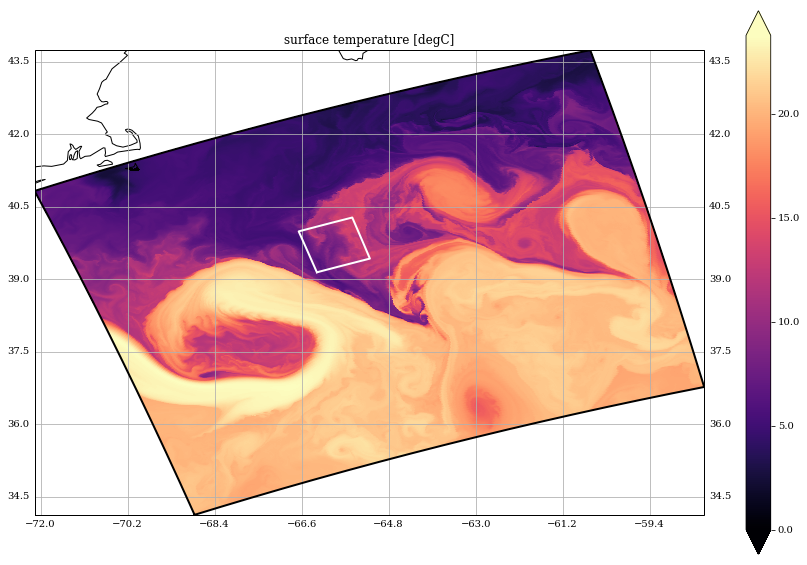

In [2]:
# load temperature
T = Dataset(ofile)['temp']
print T

#
crs = ccrs.PlateCarree()

fig=plt.figure(figsize=(15,10))
#
ax=plt.axes(projection=crs)
ax.set_extent(grd.hextent, crs)
gl=ax.gridlines(crs=crs,draw_labels=True)
gl.xlabels_top = False
ax.coastlines(resolution='50m')
#
it = 0
iz = -1
ilon = grd.Lp/2  # used for vertical slices
toplt = T[it,iz,:,:]
# should probably mask T
cmap = plt.get_cmap('magma')
im = ax.pcolormesh(grd.lon_rho,grd.lat_rho,toplt,
                   vmin=toplt.min(),vmax=toplt.max(), 
                   cmap=cmap)
cbar = plt.colorbar(im, format='%.1f', extend='both')
ax.set_title('surface temperature [degC]')
grd.plot_domain(ax,color='black',lw=2)
zgrd.plot_domain(ax,color='white',lw=2)
#plt.savefig('figs/T_hmap.png',dpi=300)

---

## isothermal displacements

To warm up we first look at isothermal displacements

---

(-1000.0, 0.0)

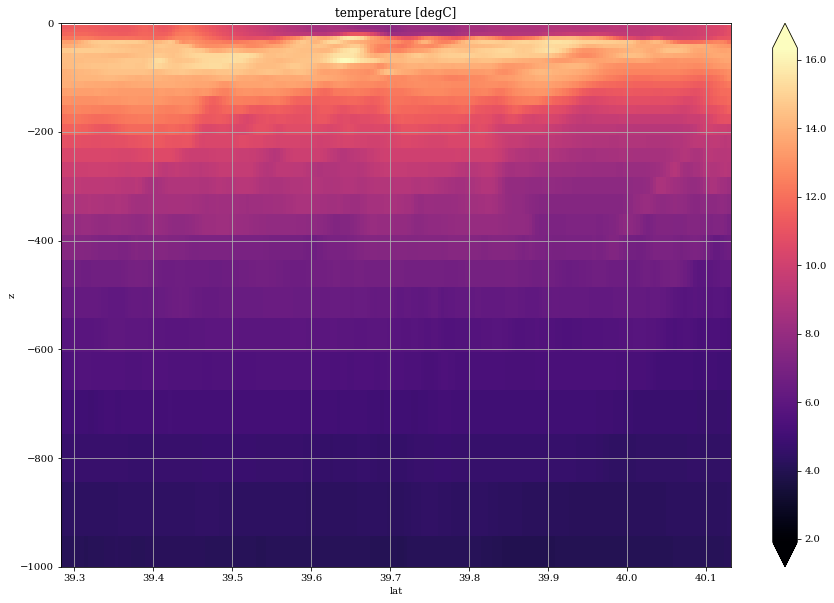

In [3]:
# interpolate on now a horizontally uniform grid

it = 0
ilon = zgrd.Lp/2  # used for vertical slices
lon = zgrd.lon_rho[None,:,ilon]
lat = zgrd.lat_rho[None,:,ilon]
h = zgrd.h[None,:,ilon]
zeta = Dataset(ofile)['zeta'][:][:,zgrd.ij[0],zgrd.ij[1]][[it],:,ilon]
z = zgrd.get_z(zeta,h,zgrd.sc_r[:,None],zgrd.Cs_r[:,None])
#
ilat=0
z_uni = z[:,ilat,None]
T_uni = interp2z0(z_uni, z[:,:,None], T[it,:,zgrd.ij[0],zgrd.ij[1]][:,:,[ilon]])[:,:,0]

plt.figure(figsize=(15,10))
ax=plt.subplot(111)
toplt = T_uni
cmap = plt.get_cmap('magma')
im = ax.pcolormesh(lat,z_uni,toplt,cmap=cmap)
cbar = plt.colorbar(im, format='%.1f', extend='both')
ax.set_xlabel('lat')
ax.set_ylabel('z')
ax.set_title('temperature [degC]')
ax.grid(True)
ax.set_ylim([-1000.,0.])


/home1/homedir5/perso/aponte/.miniconda2/envs/cognac/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home1/homedir5/perso/aponte/.miniconda2/envs/cognac/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


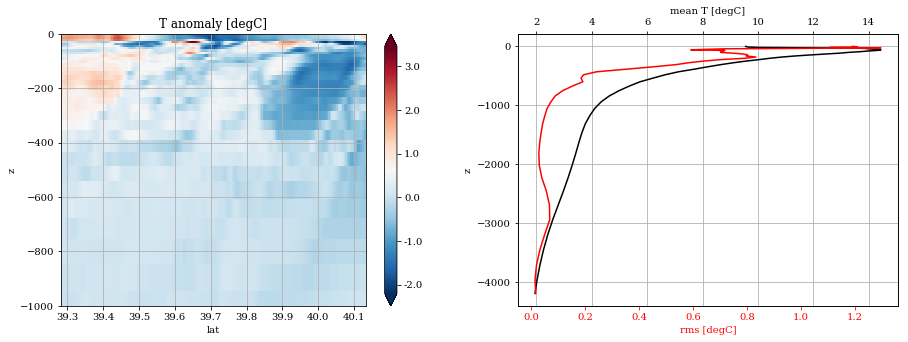

In [4]:
# compute the reference thermal stratifcation
T_mean = np.nanmean(T_uni,axis=1,keepdims=True)
T_rms = np.nanstd(T_uni,axis=1,keepdims=True)

cmap = plt.get_cmap('RdBu_r')

plt.figure(figsize=(15,5))
ax=plt.subplot(121)
toplt = T_uni-T_mean
im = ax.pcolormesh(lat,z_uni,toplt,cmap=cmap)
cbar = plt.colorbar(im, format='%.1f', extend='both')
ax.set_xlabel('lat')
ax.set_ylabel('z')
ax.set_title('T anomaly [degC]')
ax.grid(True)
ax.set_ylim([-1000.,0.])

ax=plt.subplot(122)
ax.plot(T_mean,z_uni,'k')
ax.set_ylabel('z')
#ax.set_title('sound speed, mean [m/s]')
ax.set_xlabel('mean T [degC]')
ax.grid(True)
ax.xaxis.set_label_position('top') 

ax2 = ax.twiny()
ax2.plot(T_rms,z_uni,'r')
ax2.set_xlabel('rms [degC]', color='r')
ax2.tick_params('x', colors='r')
ax2.xaxis.set_label_position('bottom') 
ax2.xaxis.tick_bottom()

ax.xaxis.tick_top()


/home1/homedir5/perso/aponte/.miniconda2/envs/cognac/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


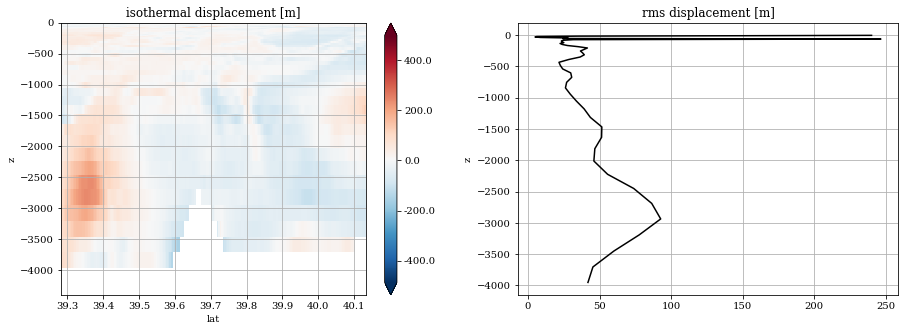

In [5]:
# compute the isothermal displacement
dTdz = np.diff(T_mean,axis=0)/np.diff(z_uni,axis=0)
dTdz = np.vstack((dTdz[0],dTdz,dTdz[-1]))
dTdz = .5*(dTdz[:-1]+dTdz[1:])

eta = (T_uni-T_mean)/dTdz


plt.figure(figsize=(15,5))
ax=plt.subplot(121)
toplt = eta
toplt[np.where(np.abs(toplt)>500)]=np.NaN

im = ax.pcolormesh(lat,z_uni,toplt,cmap=cmap)
cbar = plt.colorbar(im, format='%.1f', extend='both')
ax.set_xlabel('lat')
ax.set_ylabel('z')
ax.set_title('isothermal displacement [m]')
ax.grid(True)

ax=plt.subplot(122)
ax.plot(np.nanstd(eta,axis=1),z_uni,'k')
#ax.plot(dTdz,z_uni,'k')
ax.set_ylabel('z')
ax.set_title('rms displacement [m]')
ax.grid(True)

(50, 1)
(1, 200)


/home1/homedir5/perso/aponte/.miniconda2/envs/cognac/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


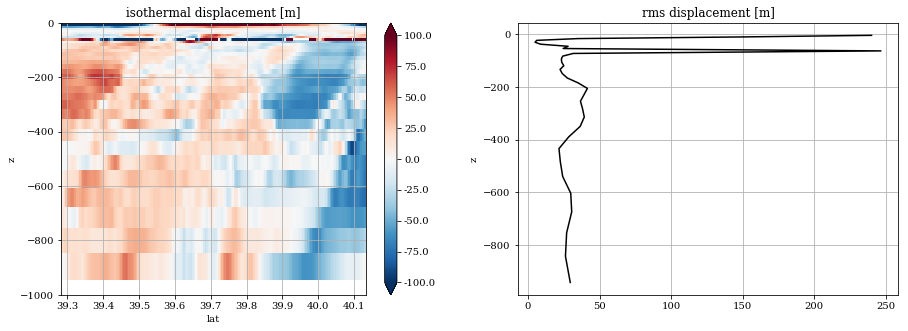

In [6]:
# same but mask points below 1000m depth
dTdz = np.diff(T_mean,axis=0)/np.diff(z_uni,axis=0)
dTdz = np.vstack((dTdz[0],dTdz,dTdz[-1]))
dTdz = .5*(dTdz[:-1]+dTdz[1:])

eta = (T_uni-T_mean)/dTdz

print z_uni.shape
print lat.shape

plt.figure(figsize=(15,5))
ax=plt.subplot(121)
toplt = eta
toplt[np.where(np.abs(toplt)>500.)]=np.NaN
toplt[np.where((z_uni+0.*lat)<-1000.)]=np.NaN

im = ax.pcolormesh(lat,z_uni,toplt,cmap=cmap, vmin=-100.,vmax=100.)
cbar = plt.colorbar(im, format='%.1f', extend='both')
ax.set_xlabel('lat')
ax.set_ylabel('z')
ax.set_title('isothermal displacement [m]')
ax.grid(True)
ax.set_ylim([-1000.,0.])

ax=plt.subplot(122)
ax.plot(np.nanstd(eta,axis=1),z_uni,'k')
#ax.plot(dTdz,z_uni,'k')
ax.set_ylabel('z')
ax.set_title('rms displacement [m]')
ax.grid(True)

---

---

---